## DESEQ analysis of cardiomyocytes infected with covid19

**Setting up**

In [79]:
library("DESeq2")
library(scales)
library(dplyr)
options(repr.plot.width=4, repr.plot.height=3)

In [60]:
setwd(path.expand("/mnt/storage/r0624449/jupyternotebooks/Project2/DESEQ/"))

**Load count file**

In [61]:
matrixFile = path.expand("/mnt/storage/r0624449/jupyternotebooks/Project2/featurecount/all.gene.counts")

**Position of case columns is switched with control columns so controls are first**

In [65]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
colnames(countData) <- c("Case1", "Case2", "Case3", "Control1", "Control2", "Control3")
countData <- countData[,c(4,5,6,1,2,3)]
head(countData)

,Control1,Control2,Control3,Case1,Case2,Case3
MIR1302-11,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0
OR4F5,4,0,0,0,0,1
RP11-34P13.7,1,8,1,2,0,0
RP11-34P13.8,0,0,0,0,0,0
AL627309.1,38,50,38,13,12,10


**Cases have almost half the amount of reads than controls (likely due to the reads from covid)**

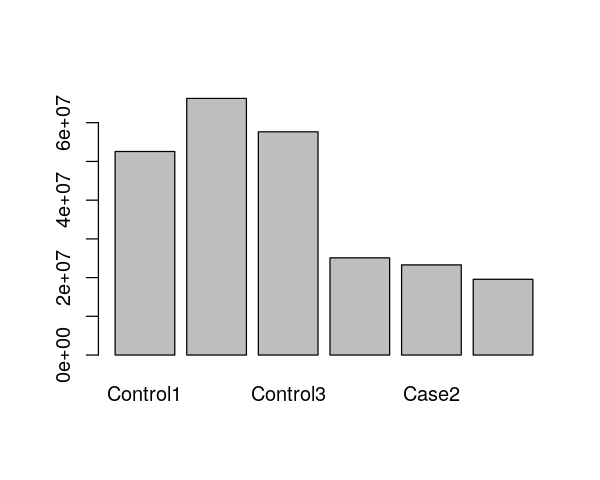

In [66]:
barplot(colSums(countData))

**Creating the DDS object and running deseq**

In [67]:
condition <- factor(c("Control", "Control", "Control", "Case", "Case", "Case"), levels = c("Control", "Case"))
print(condition)

[1] Control Control Control Case    Case    Case   
Levels: Control Case


In [68]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
Control1,Control
Control2,Control
Control3,Control
Case1,Case
Case2,Case
Case3,Case


In [69]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)

In [70]:
dds

class: DESeqDataSet 
dim: 41863 6 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(6): Control1 Control2 ... Case2 Case3
colData names(2): sampleName condition

In [71]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



**QC**

**Pairwise plot: we see that cases are similar (linear) and that there is a difference between cases and controls (as expected). Control 2 does seem to differ from the other controls (we also saw this in the fastqc report)**

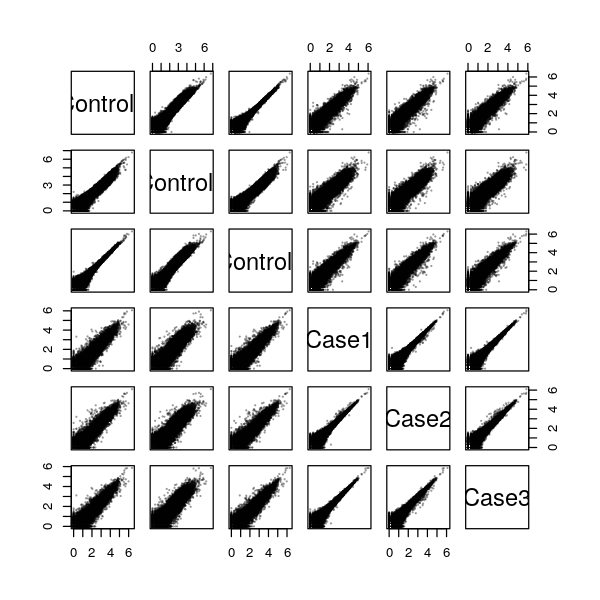

In [72]:
options(repr.plot.width=5, repr.plot.height=5)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

**MAplot: A large amount of genes seem to be differentially expressed** 

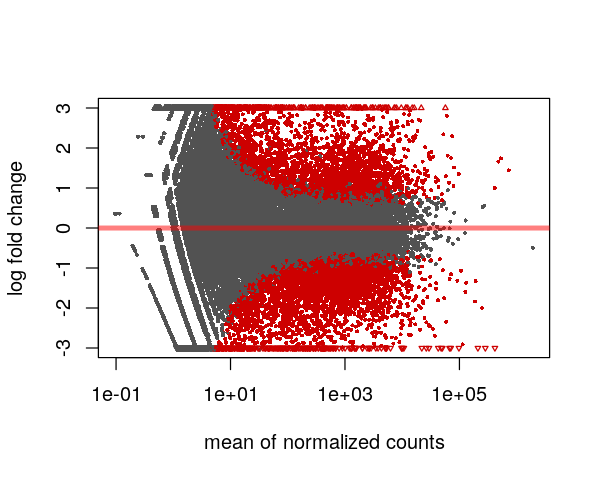

In [73]:
options(repr.plot.width=5, repr.plot.height=4)
plotMA(dds,ylim=c(-3,3))

In [74]:
res <- results(dds)
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition Case vs Control 
Wald test p-value: condition Case vs Control 
DataFrame with 6 rows and 6 columns
                baseMean    log2FoldChange             lfcSE              stat
               <numeric>         <numeric>         <numeric>         <numeric>
CXCL2   555.965633773451  5.60643073911983 0.326653433704861  17.1632383457061
PTGS2   5337.83854138259  7.11307707143512 0.447746823467792  15.8863819878038
IL11    1283.52884235019  8.44593785557123 0.549874172773849  15.3597646039012
NUAK2   1642.80680012694  4.71288893453476 0.309378274468511  15.2334191618049
ANGPTL4 7479.57266756581  6.60243317319434 0.462909530532872  14.2629017933462
LDB3    9737.80526487847 -3.68162002017875 0.261998718830417 -14.0520535238256
                      pvalue                 padj
                   <numeric>            <numeric>
CXCL2   5.00437923445862e-66 1.07569131644688e-61
PTGS2   7.87431764721388e-57 8.46292289134312e-53
IL11    3.04678870366037e-53 2.1830

**5423 genes are differentially expressed!**

In [75]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 5423    6

**Genes I picked as positive control genes are TNF which is related to TNF-alpha which is known to play a role in inflammation. The infected tissue should be inflammed so it is expected to be upregulated in cases <br> Similarly IL12(A) should also be upregulated**

 **TNF**
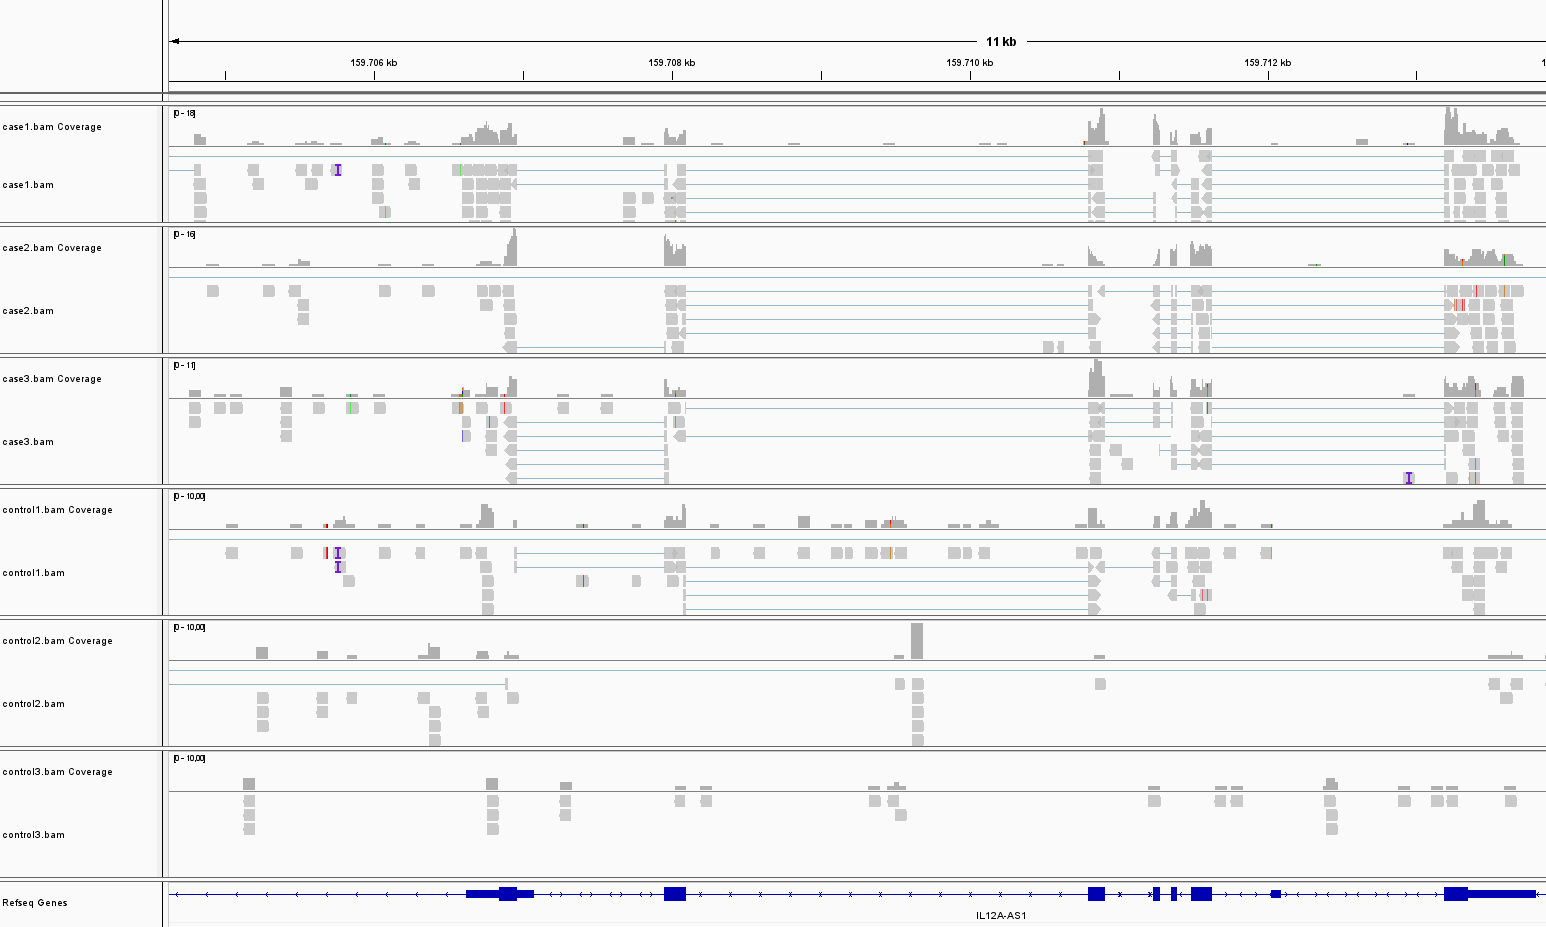
**IL12A**
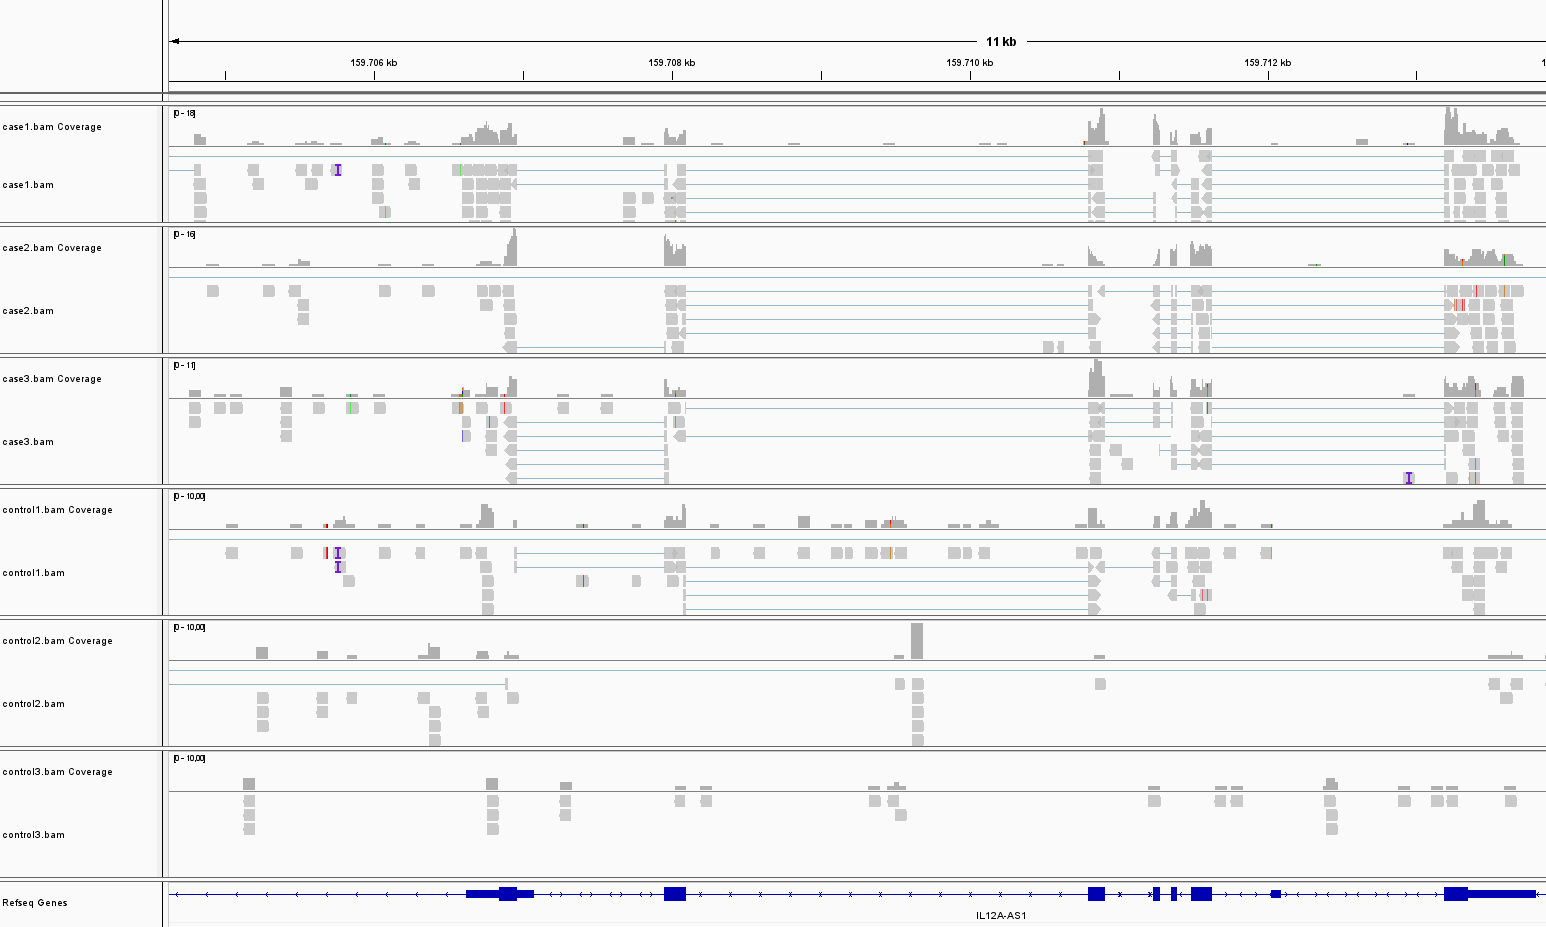

**Extract columns of result file for rows that have a logfold change of +/- 1 and are significantly differentialy expressed (p<=0.05). Multiple files are created as input for the different visualisation tools**

In [113]:
#full set
df = as.data.frame(res)

upregulated = filter(df, log2FoldChange >= 1 & pvalue <= 0.05)
downregulated = filter(df, log2FoldChange <= 1 & pvalue <= 0.05)
#Gorilla
SortedAs = arrange(df, log2FoldChange)
SortedGeneNameAs = rownames(SortedAs)
SortedDe = arrange(df, desc(log2FoldChange))
SortedGeneNameDe = rownames(SortedDe)
#Humanmine or g:profiler
upgenenames <- rownames(upregulated)
downgenenames <- rownames(downregulated)

#GSEA
GSEAas = paste(SortedGeneNameAs, SortedAs[,3])
GSEAde = paste(SortedGeneNameDe, SortedDe[,3])

write.table(df, "deseqresult.txt", append = FALSE, sep = "\t", dec = ".",
            row.names = TRUE, col.names = TRUE, quote = FALSE)
write.table(upregulated, "upregulated.txt", append = FALSE, sep = " ", dec = ".",
            row.names = TRUE, col.names = TRUE, quote = FALSE)
write.table(downregulated, "downregulated.txt", append = FALSE, sep = " ", dec = ".",
            row.names = TRUE, col.names = TRUE, quote = FALSE)
write.table(upgenenames, "upgenenames.txt", append = FALSE, sep = " ", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(downgenenames, "downgenenames.txt", append = FALSE, sep = " ", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(SortedGeneNameAs, "sortedgenenameAs.txt", append = FALSE, sep = "\t", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(SortedGeneNameDe, "sortedgenenameDe.txt", append = FALSE, sep = "\t", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(GSEAas, "GSEAas.rnk", append = FALSE, sep = " \t", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(GSEAde, "GSEAde.rnk", append = FALSE, sep = " \t", dec = ".",
            row.names = FALSE, col.names = FALSE, quote = FALSE)

## The functional analysis is carried out in the master notebook (/mnt/storage/r0624449/jupyternotebooks/Project2 Master)